# ДЗ 2 — Бейзлайн для задачи оттока клиентов (Telecom Churn)

## Что делаю
1) Загружаю тот же датасет (Kaggle Telco Churn).  
2) Минимальная чистка.  
3) Train/Test со стратификацией.  
4) Константа (мажоритарный класс).  
5) Бейзлайн‑модели: LogisticRegression и DecisionTree.  
6) Сравниваю F1(Yes) на тесте.

## Метрика качества
Используем **F1-score для позитивного класса (`Churn=Yes`)** как основную метрику.

In [30]:
# Импорты
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, RocCurveDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Данные

Использую тот же набор **Telco Customer Churn** (Kaggle).

Минимальная чистка: `TotalCharges` → float, удалить пропуски в нём, удалить `customerID`.


In [31]:
try:
    import kagglehub
except ImportError:
    !pip install -q kagglehub
    import kagglehub

path = kagglehub.dataset_download("blastchar/telco-customer-churn")

csv_path = None
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".csv") and "Telco" in f:
            csv_path = os.path.join(root, f); break
    if csv_path: break

df = pd.read_csv(csv_path)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)
if "customerID" in df.columns: df = df.drop(columns=["customerID"])

df.shape, df["Churn"].value_counts(normalize=True).round(3)

((7032, 20),
 Churn
 No     0.734
 Yes    0.266
 Name: proportion, dtype: float64)

## Train/Test
`test_size=0.25`, `stratify=y`, `random_state=42`.

In [32]:
X = df.drop("Churn", axis=1); y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
y_train.value_counts(normalize=True).round(3), y_test.value_counts(normalize=True).round(3)

(Churn
 No     0.734
 Yes    0.266
 Name: proportion, dtype: float64,
 Churn
 No     0.734
 Yes    0.266
 Name: proportion, dtype: float64)

## 3. Константный бейзлайн
Берём **наиболее частый класс** и считаем метрики на тесте.

In [33]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred_const = dummy.predict(X_test)
print(f"[Constant] Acc={accuracy_score(y_test, y_pred_const):.3f} | F1(Yes)={f1_score(y_test, y_pred_const, pos_label='Yes', zero_division=0):.3f}")

[Constant] Acc=0.734 | F1(Yes)=0.000


## Бейзлайны
**Как кодирую категории:** много номинальных полей → `get_dummies(drop_first=True)`.  
Тест выравниваю по колонкам трейна (`reindex`). Это простой и прозрачный вариант.

Почему One‑Hot, а не Label Encoding?
- Наши категориальные признаки **номинальные** → у них нет порядка.  
- Label Encoding добавляет фиктивный порядок (0<1<2), что может ввести модель в заблуждение.
- **One‑Hot** не навязывает порядок и хорошо работает с логистической регрессией и деревьями.


In [34]:
# One‑Hot Encoding
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  drop_first=True)
X_test_enc  = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
X_train_enc.shape, X_test_enc.shape

((5274, 30), (1758, 30))

## 5. Простые модели (бейзлайны) и оценка на тесте
### 5.1 Logistic Regression
Лёгкая линейная модель. Хороший «первый ориентир».

In [39]:
logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=200)
logreg.fit(X_train_enc, y_train)
y_pred_lr = logreg.predict(X_test_enc)
print(f"[LogReg] Acc={accuracy_score(y_test, y_pred_lr):.3f} | F1(Yes)={f1_score(y_test, y_pred_lr, pos_label='Yes'):.3f}")
print("\nReport (LogReg)\n", classification_report(y_test, y_pred_lr, target_names=["No Churn","Churn"]))

[LogReg] Acc=0.801 | F1(Yes)=0.604

Report (LogReg)
               precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1291
       Churn       0.64      0.57      0.60       467

    accuracy                           0.80      1758
   macro avg       0.75      0.73      0.74      1758
weighted avg       0.80      0.80      0.80      1758



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 640x480 with 0 Axes>

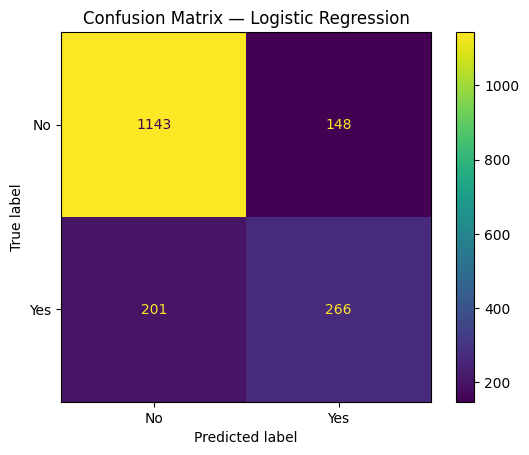

In [40]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["No","Yes"])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No","Yes"])
plt.figure()
disp_lr.plot(values_format='d')
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


### Decision Tree (простой)
Быстро проверяю дерево как альтернативный «простой» семейство моделей.

In [41]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5)
tree.fit(X_train_enc, y_train)
y_pred_tree = tree.predict(X_test_enc)
print(f"[Tree] Acc={accuracy_score(y_test, y_pred_tree):.3f} | F1(Yes)={f1_score(y_test, y_pred_tree, pos_label='Yes'):.3f}")

[Tree] Acc=0.788 | F1(Yes)=0.520


<Figure size 640x480 with 0 Axes>

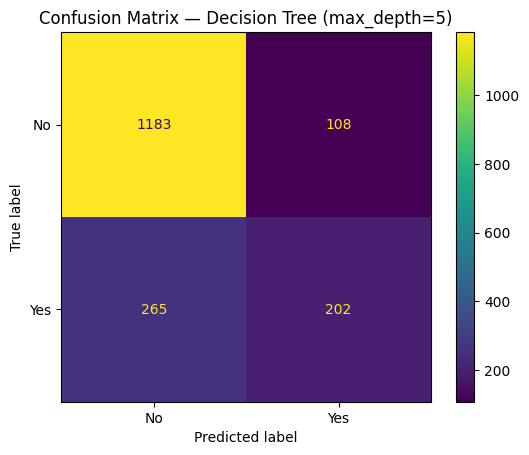

In [42]:
# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=["No","Yes"])
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["No","Yes"])
plt.figure()
disp_tree.plot(values_format='d')
plt.title("Confusion Matrix — Decision Tree (max_depth=5)")
plt.show()

## Итог
- Простой бейзлайн готов. Используем F1(Yes) как целевую метрику.
- Логистическая регрессия и дерево заметно лучше константы.  